Here, I (Ege) am looking at different ways to "remove noise" or "dampen it" so that our derivatives are not as affected by the noise. I am concerned that to what extent we can remove these noises.

Here are the methods we'll try out on this notebook:
- Savitzky-Golay Filter
- Gaussian Filter
- Total Variation Denoising (not yet)

In [ ]:
# Modules Import

from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from pathlib import Path

master_root = Path.cwd().resolve().parents[3] # Use this to import data

In [2]:
# Data Import, Options

SNR_Options = [100,120,140,160,180,200,220,240,260,280]

VZA_SNR_Options = [100,120,140,160,180,200,220,240,260,280]  

#Spectra_Range_Index = [57,137  +1] #selected range: 1500-1650, refer indices to a dataset that has rwc columns and no original indices column
                                # WARNING!!!! Write the last index +1 since python slicing STOPS at that last index and DOES NOT include it (THIS IS RELATED TO PYTHON, WILL NOT CHANGE)
                                # for 900-1700, 57,137
                                # for 1500-1650, 117, 132

                                # Not used!!!

simpler_data_rwc_handle = rf"{master_root}\Data\General_Data\simpler_data_rwc.csv" # PATH HANDLE for simpler_data_snr goes here keep .csv
simpler_data_snr_handle = rf"{master_root}\Data\General_Data\Noised_Data\simpler_data_SNR_" # PATH HANDLE for simpler_data_snr goes here omit the SNR VAL and .csv

print(simpler_data_rwc_handle)

C:\SenkDosya\UTAT\Data\General_Data\simpler_data_rwc.csv


In [3]:
# Actual Data Manipulation

# We need all data in numpy arrays


for i in SNR_Options:
    
    globals()[f'values_SNR_{i}'] = ((pd.read_csv(rf"{simpler_data_snr_handle+str(i)}.csv")).iloc[:, 5:]).to_numpy() # Using the entire range since we want to see the capabilities, not necessarily unmix

values_groundtruth = ((pd.read_csv(rf"{simpler_data_rwc_handle}")).iloc[:, 7:]).to_numpy() # Using the entire range since we want to see the capabilities, not necessarily unmix

wavelengths = np.arange(400, 2500, 10)

In [4]:
# Remove Noise Using The Models

for i in SNR_Options:

    globals()[f'savgol_SNR_{i}'] = savgol_filter(
        x= globals()[f'values_SNR_{i}'], window_length= 9, polyorder= 2
        )
    
    globals()[f'gaussian_SNR_{i}'] = gaussian_filter1d(
        input= globals()[f'values_SNR_{i}'], sigma= 1.5
    )

    # Find the diff matrices

    globals()[f'diff_savgol_SNR_{i}'] = globals()[f'savgol_SNR_{i}'] - values_groundtruth
    globals()[f'diff_gaussian_SNR_{i}'] = globals()[f'gaussian_SNR_{i}'] - values_groundtruth

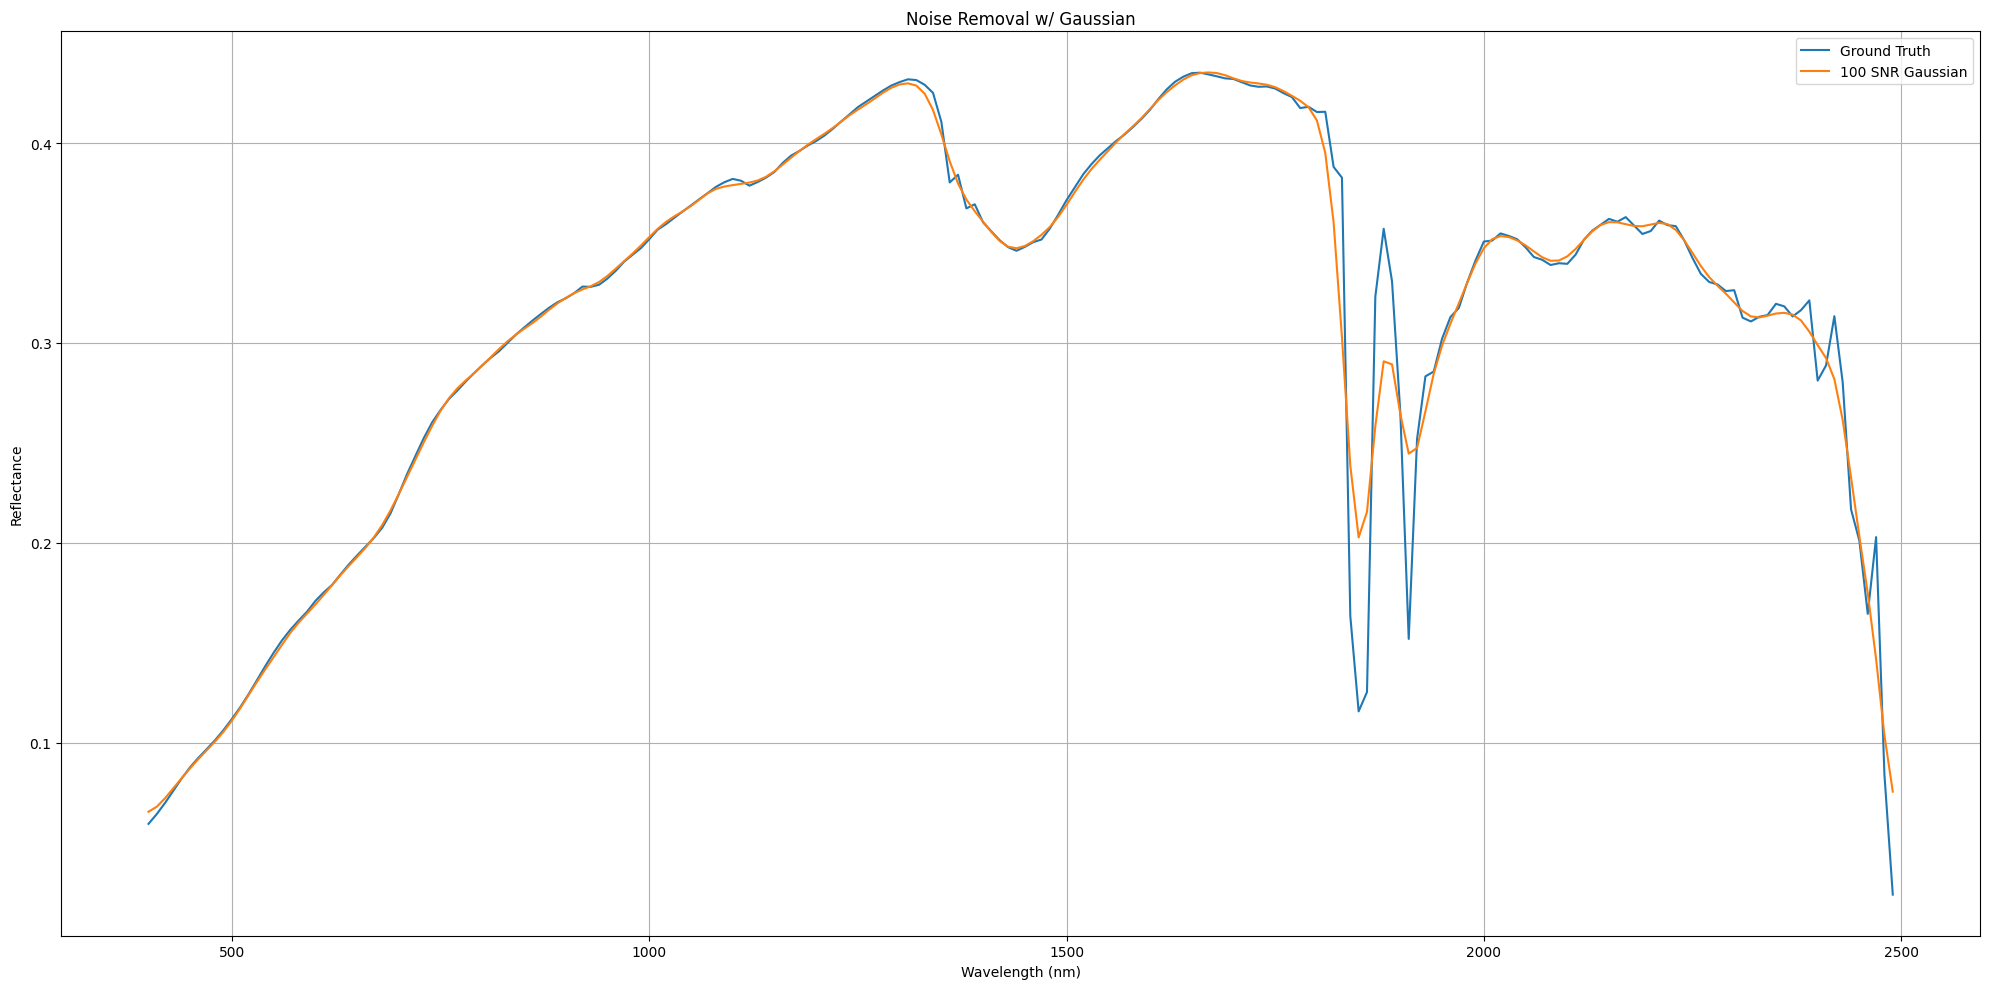

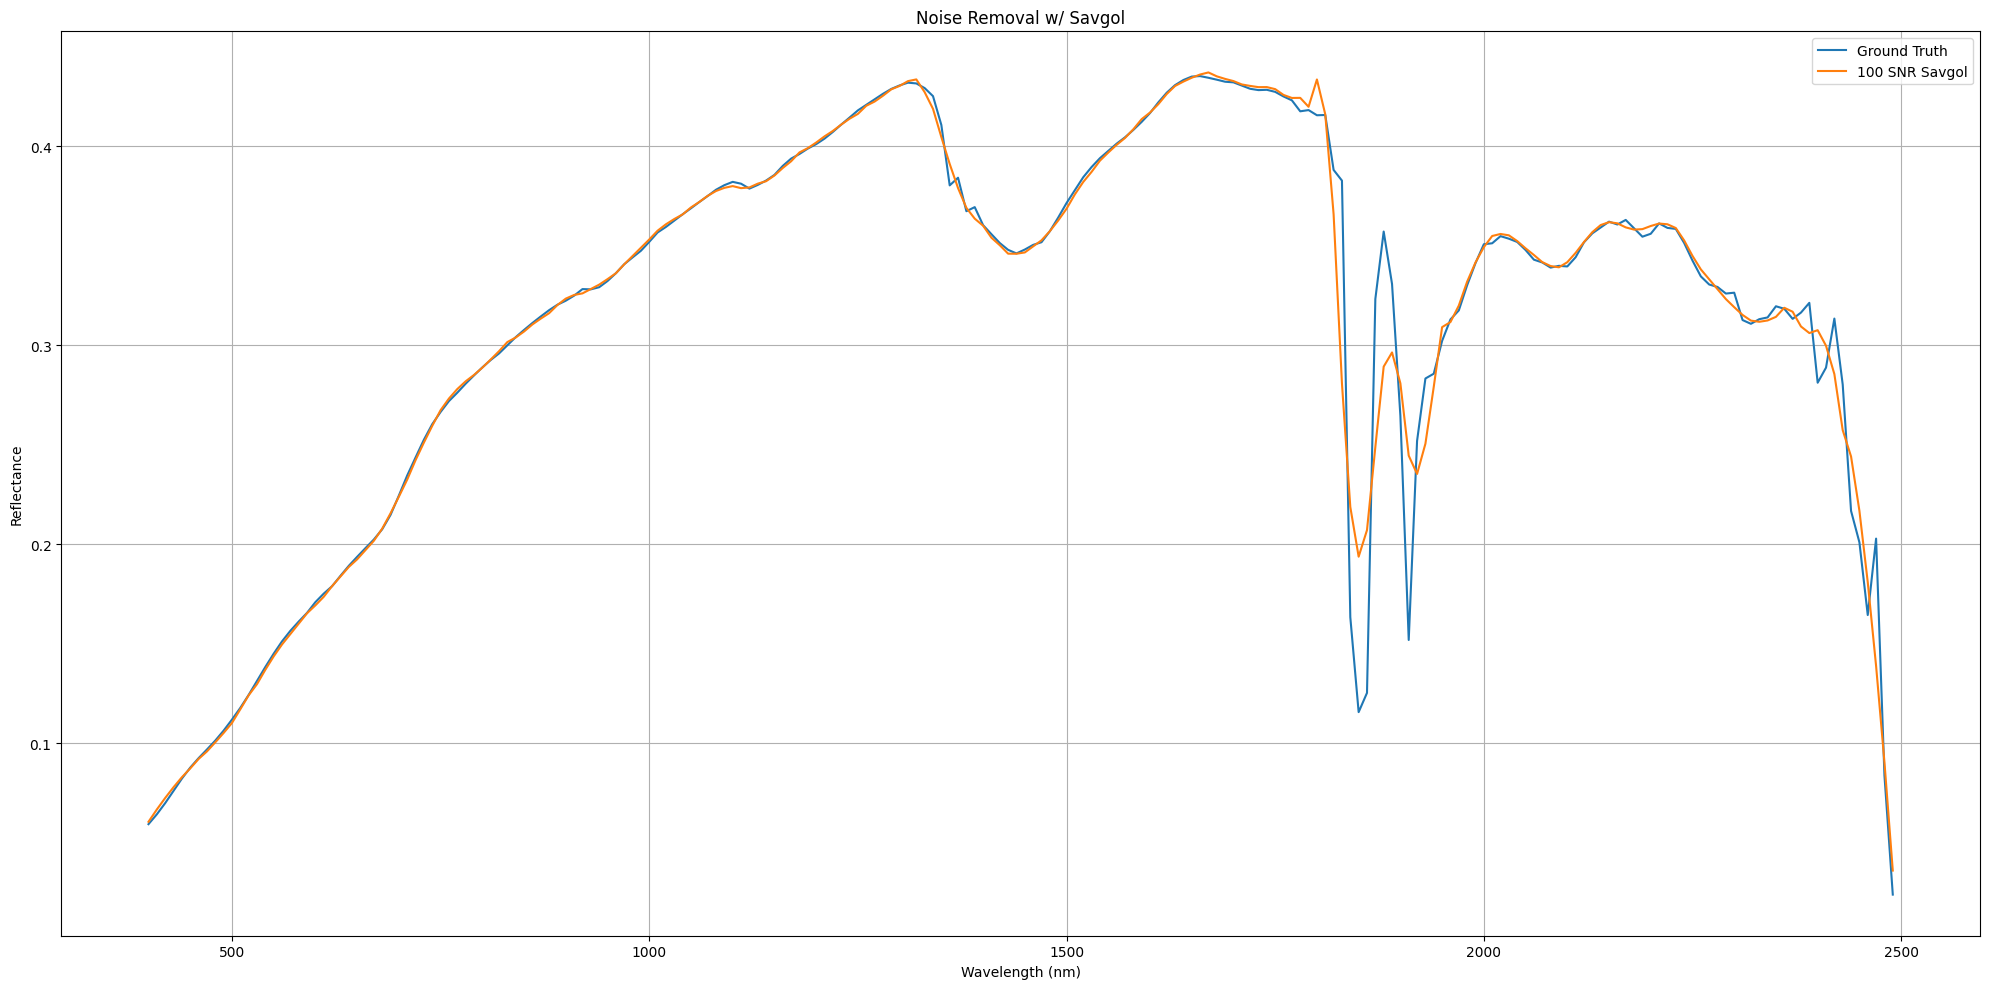

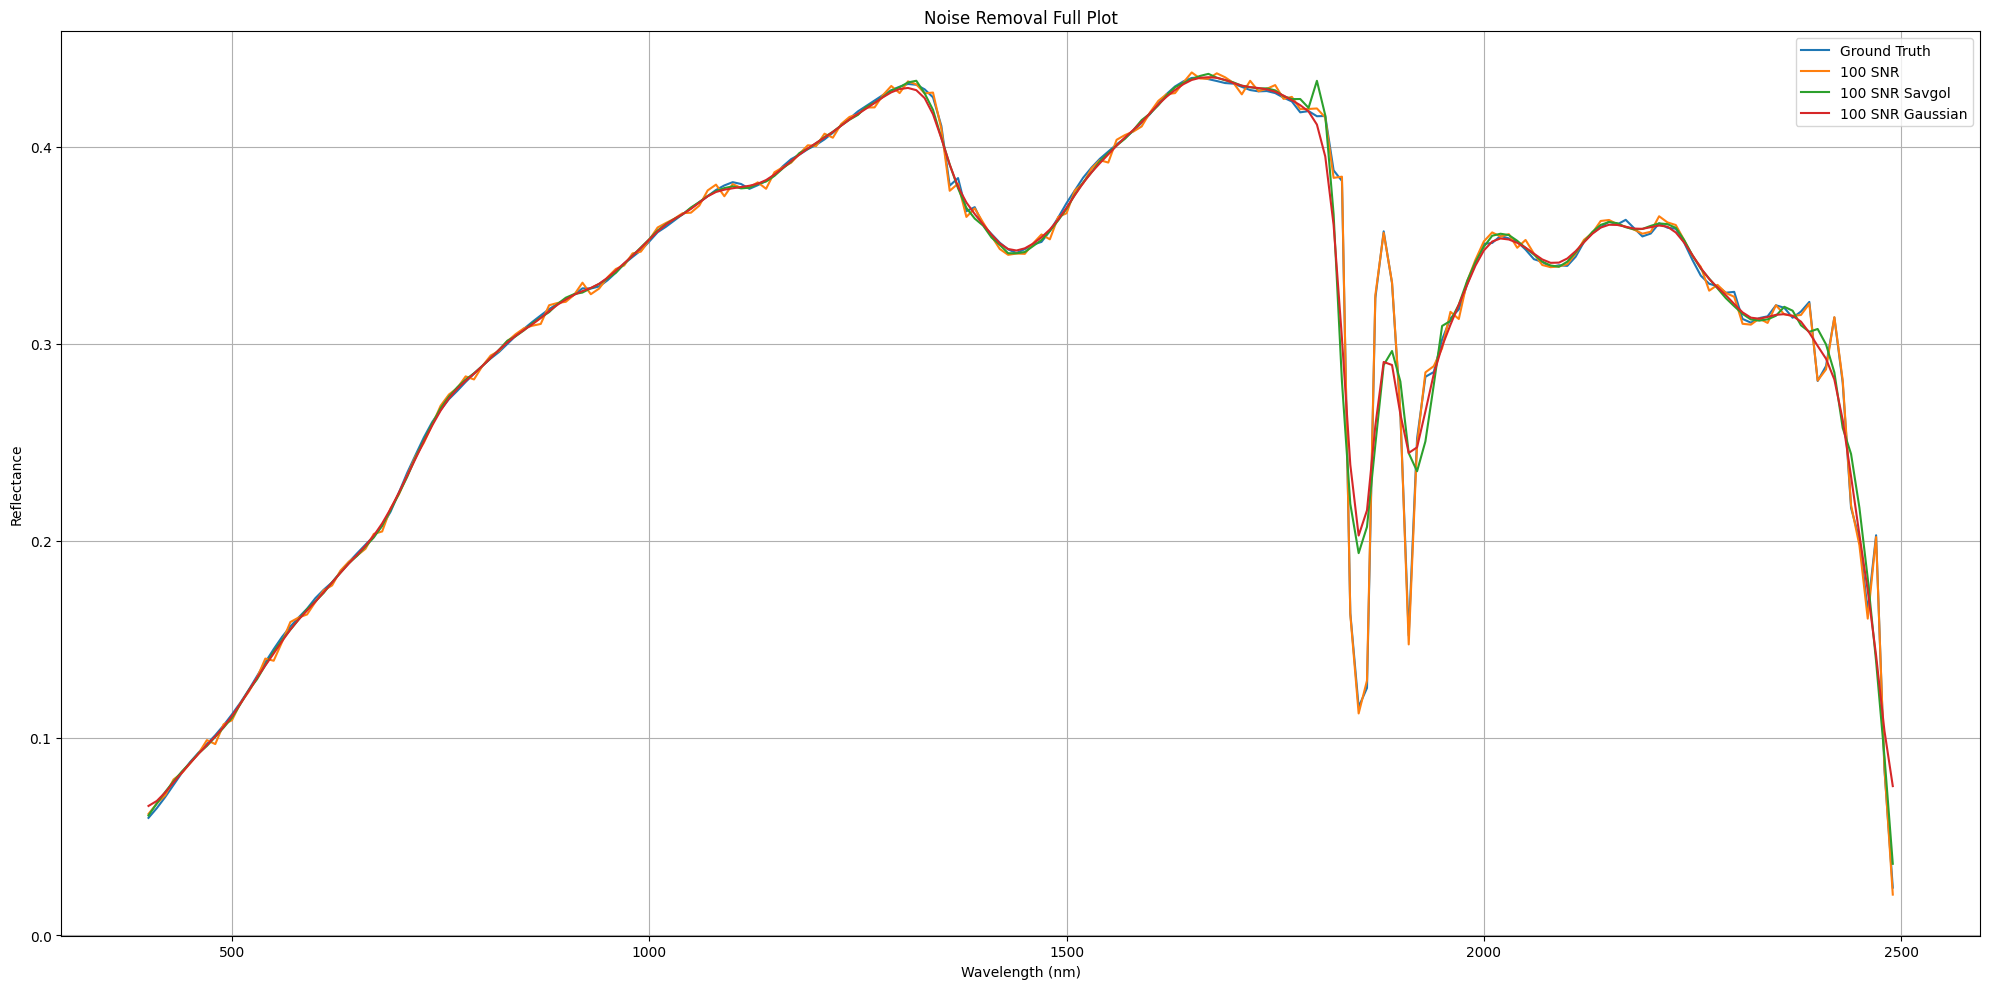

In [5]:
plt.figure(figsize=(20,10))
plt.plot(wavelengths, values_groundtruth[0], label = 'Ground Truth')
plt.plot(wavelengths, gaussian_SNR_100[0], label= '100 SNR Gaussian')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Noise Removal w/ Gaussian')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(wavelengths, values_groundtruth[0], label = 'Ground Truth')
plt.plot(wavelengths, savgol_SNR_100[0], label= '100 SNR Savgol')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Noise Removal w/ Savgol')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(wavelengths, values_groundtruth[0], label = 'Ground Truth')
plt.plot(wavelengths, values_SNR_100[0], label= '100 SNR')
plt.plot(wavelengths, savgol_SNR_100[0], label= '100 SNR Savgol')
plt.plot(wavelengths, gaussian_SNR_100[0], label= '100 SNR Gaussian')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Noise Removal Full Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
from ipywidgets import interact, IntSlider, Dropdown
from IPython.display import clear_output

def plot_diff_heatmap(snr, filter_type):
    clear_output(wait=True)
    diff = globals()[f'diff_{filter_type}_SNR_{snr}']
    plt.figure(figsize=(12,6))
    plt.imshow(diff, aspect='auto', cmap= 'plasma', origin= 'lower', extent=[wavelengths[0], wavelengths[-1], 0, diff.shape[0]])
    plt.colorbar(label= 'Difference')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Sample Index')
    plt.title(f'Difference on {snr} using {filter_type}')
    plt.show()

interact(plot_diff_heatmap, snr=IntSlider(min=100, max=280, step= 20, value= 100), filter_type= Dropdown(options=['savgol', 'gaussian'], value='savgol'))



interactive(children=(IntSlider(value=100, description='snr', max=280, min=100, step=20), Dropdown(description…

<function __main__.plot_diff_heatmap(snr, filter_type)>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_diff(snr, filter_type):

    clear_output(wait=True)
    diff = globals()[f'diff_{filter_type}_SNR_{snr}']

    n_samples, n_bands = diff.shape

    x, z = np.meshgrid(wavelengths, np.arange(n_samples))

    x = x.flatten()
    y = diff.flatten()
    z = z.flatten()

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c=y, cmap='plasma', s=2, alpha=0.6)

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Difference')
    ax.set_zlabel('Sample Index')
    ax.set_title(f'3D Difference Plot — {filter_type}, SNR: {snr}')
    plt.tight_layout()
    plt.show()

interact(
    plot_3d_diff,
    snr=IntSlider(min=100, max=280, step=20, value=100),
    filter_type=Dropdown(options=['savgol', 'gaussian'], value='savgol')
)

interactive(children=(IntSlider(value=100, description='snr', max=280, min=100, step=20), Dropdown(description…

<function __main__.plot_3d_diff(snr, filter_type)>